<a href="https://colab.research.google.com/github/jcfarese/MLA_JCF/blob/main/Classification_In_class_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Survival Prediction: Model Selection and Hyperparameter Tuning

In this notebook, you will:
1. Load the Titanic dataset from an online source.
2. Perform basic EDA to understand the data.
3. Use pipelines to preprocess numerical and categorical data.
4. Train and evaluate multiple classification models (KNN, SVC, Random Forest, Decision Tree, Logistic Regression, Bagging, and Boosting).
5. Conduct hyperparameter tuning to find the best model.
6. Write reflection on the findings

---

## 1. Importing Libraries
**Task**: Import the necessary libraries for data handling, visualization, model training, and evaluation.

In [22]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## 2. Load the titanic dataset from seaborn

In [2]:
titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
#Columns
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

## 3. Basic EDA (Exploratory Data Analysis)
Question 1: What is the shape of the dataset?

In [4]:
#Shape of the dataset
titanic.shape

(891, 15)

Question 2: Are there any missing values?

In [5]:
#Missing values
titanic.isnull().sum()

,0
survived,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
class,0
who,0


Question 3: Visualize some relationships (atleast 3). such as:

- The distribution of numerical features like age and fare.
- The survival rate by different classes, gender, etc.

In [6]:
#Check the distributions
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


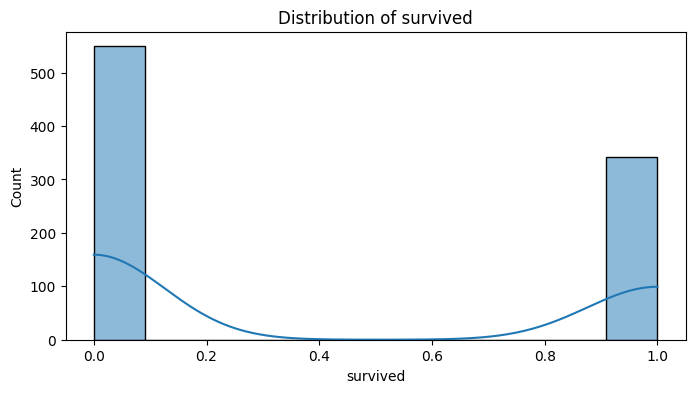

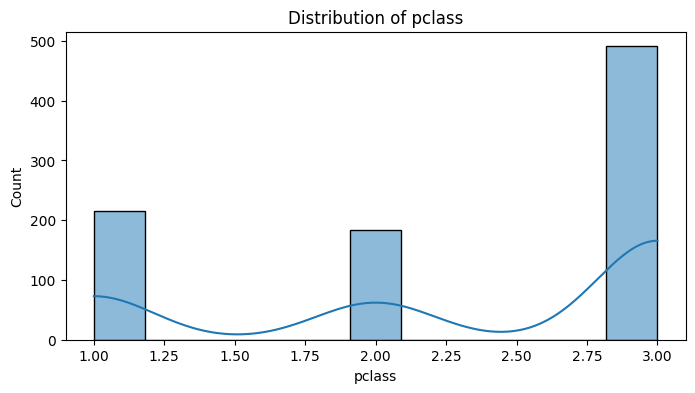

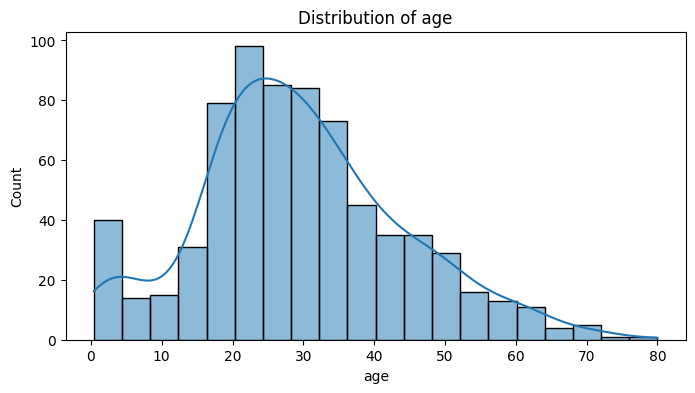

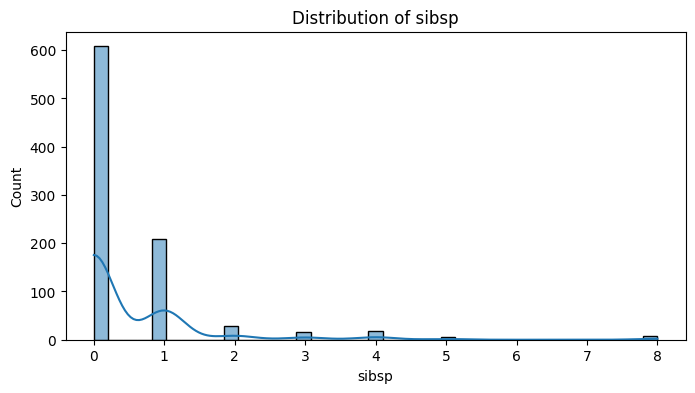

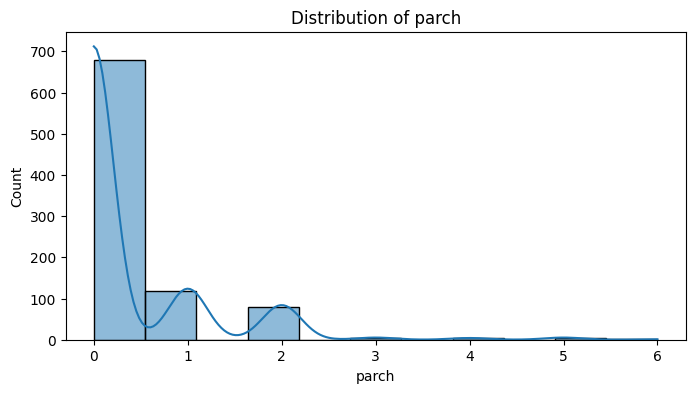

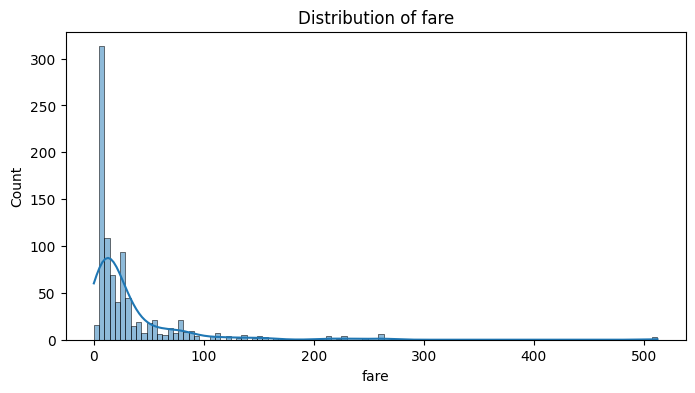

In [7]:
#Identify the numerical columns
numerical_columns = titanic.select_dtypes(include=['number']).columns

#Plot the distributions
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=titanic, x=column, kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

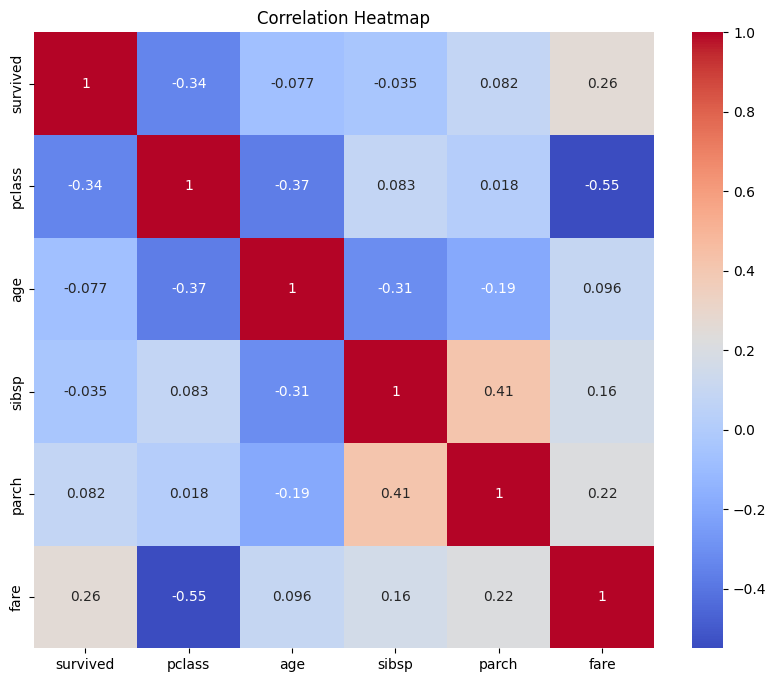

In [8]:
#Create a heatmap for the numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(titanic[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

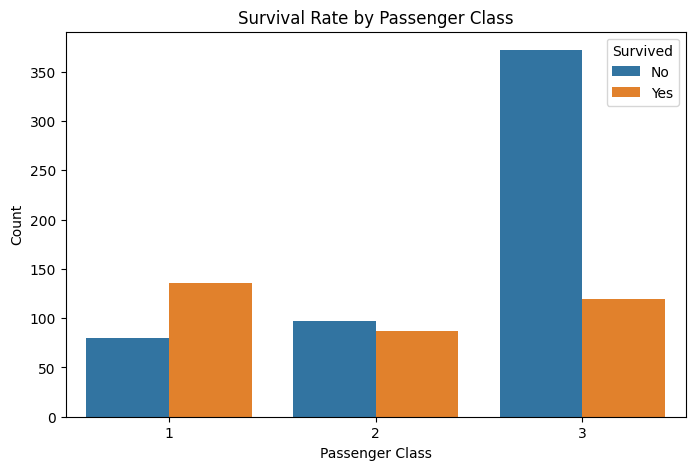

In [10]:
#Survivor Rate by PClass
plt.figure(figsize=(8, 5))
sns.countplot(data=titanic, x='pclass', hue='survived')
plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

<ipython-input-11-1f03297eb9ef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=titanic, x='survived', y='age', palette='muted', split=True)


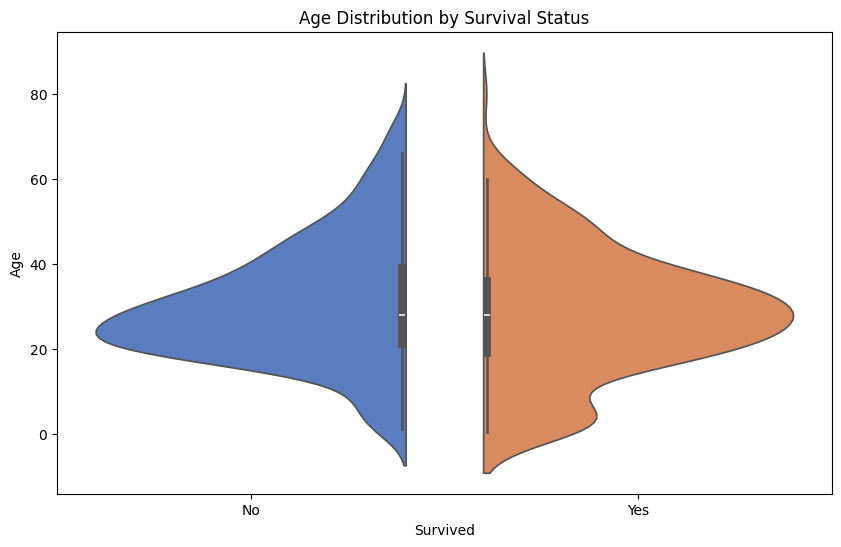

In [11]:
#Survivor Rate by Age
plt.figure(figsize=(10, 6))
sns.violinplot(data=titanic, x='survived', y='age', palette='muted', split=True)
plt.title('Age Distribution by Survival Status')
plt.xlabel('Survived')
plt.ylabel('Age')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

<Figure size 1000x600 with 0 Axes>

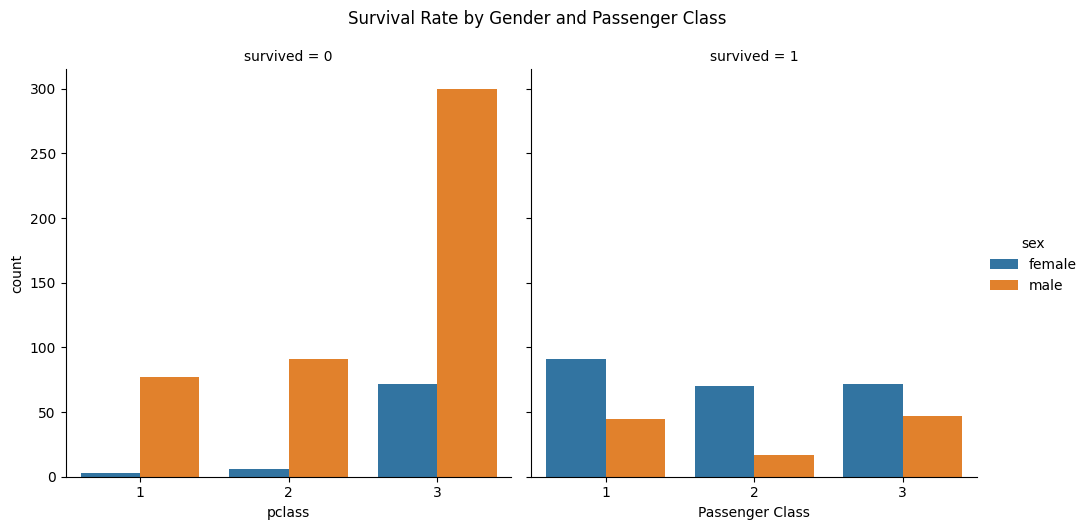

In [12]:
# Survival Rate by Gender and Passenger Class
plt.figure(figsize=(10, 6))
sns.catplot(data=titanic, x='pclass', hue='sex', col='survived', kind='count', height=5, aspect=1)
plt.suptitle('Survival Rate by Gender and Passenger Class', y=1.05)
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.show()


### Split the data into training and testing sets

In [13]:
# Split the data into features and target
X = titanic[['age', 'fare', 'pclass', 'sex', 'embarked', 'who', 'alone']]
y = titanic['survived']

In [14]:
#Split the data using 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Display the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (712, 7)
X_test shape: (179, 7)
y_train shape: (712,)
y_test shape: (179,)


## 4. Data Preprocessing with Pipelines
Task: Create a data preprocessing pipeline for numerical and categorical features.

- Numerical features: Use StandardScaler to scale them.
- Categorical features: Use OneHotEncoder to encode them.
- impute missing values

In [15]:
#Identify the numerical columns
numerical_columns = X.select_dtypes(include=['number']).columns

#Identify the categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [16]:
#Create a numerical transformer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

#Create a categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#Create a preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'fare', 'pclass'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sex', 'embarked', 'who'], dtype='object'))])

## Training data with multiple models

In [18]:
# Define models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Bagging Classifier': BaggingClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}



# Evaluate each model
for model_name, model in models.items():
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Print accuracy and classification report
    print(f"\nModel: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))




Model: K-Nearest Neighbors
Accuracy: 0.7877094972067039

Model: Logistic Regression
Accuracy: 0.7988826815642458

Model: Decision Tree
Accuracy: 0.7653631284916201

Model: Random Forest
Accuracy: 0.7877094972067039

Model: Support Vector Machine
Accuracy: 0.8044692737430168

Model: Bagging Classifier
Accuracy: 0.8100558659217877

Model: Gradient Boosting
Accuracy: 0.8268156424581006


The 2 highest were Bagging Classifier and Gradient Boosting

#Hyperparameter Tuning
## Define parameter grids for the top 2 models
Example:
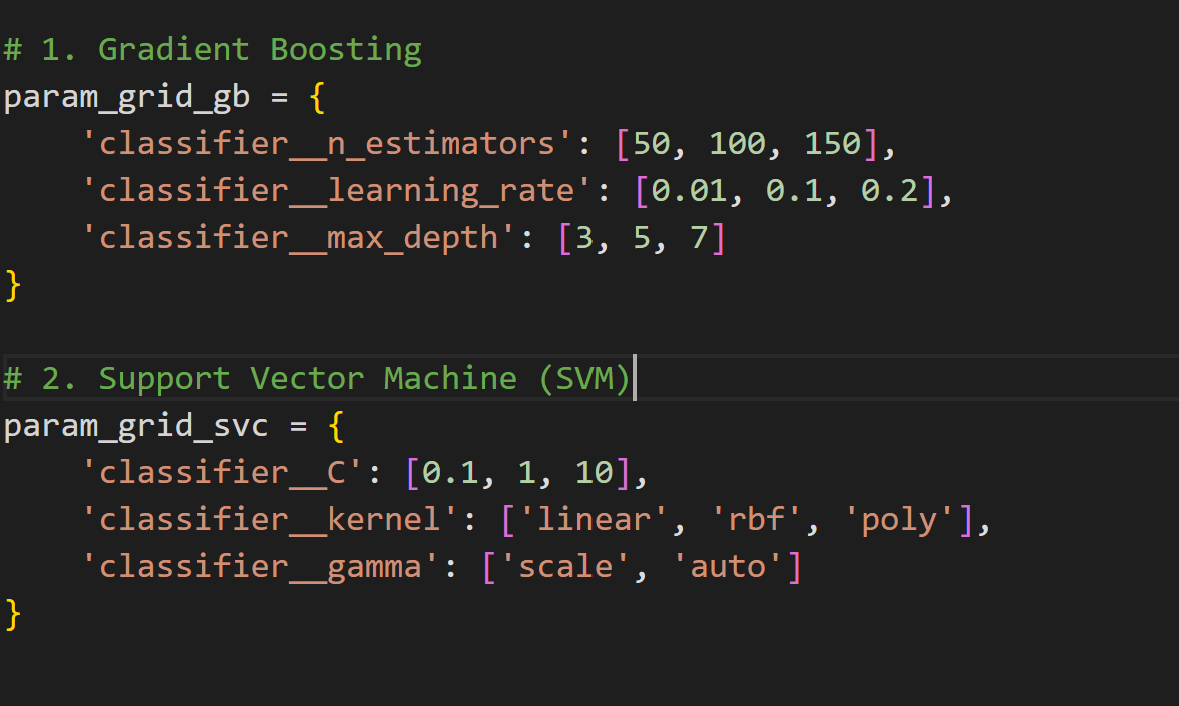

In [19]:
#Parameter Grid for Gradient Boosting
param_grid_gb = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0],
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_samples_split': [2, 5, 10]
}

In [20]:
#Parameter Grid for Bagging Classifier
param_grid_bc = {
    'classifier__n_estimators': [10, 50, 100],             # Number of base estimators in the ensemble
    'classifier__max_samples': [0.5, 0.7, 1.0],            # Proportion of samples to draw for each estimator
    'classifier__max_features': [0.5, 0.7, 1.0],           # Proportion of features to draw for each estimator
    'classifier__bootstrap': [True, False]                 # Whether samples are drawn with replacement
}

## List of models and their corresponding parameter grids
Example
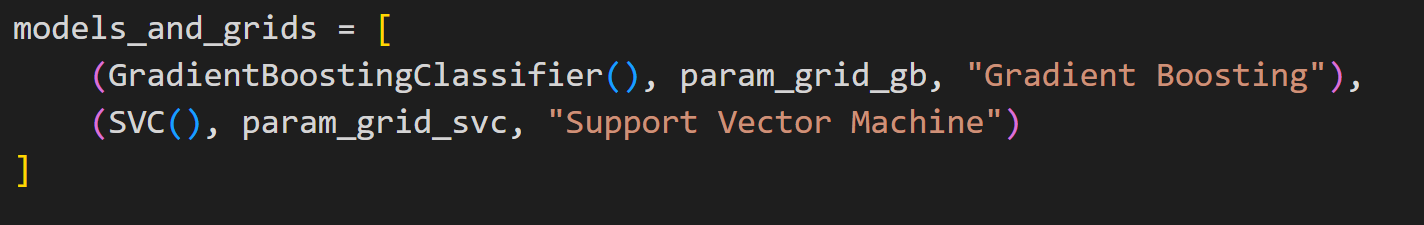

In [21]:
#Model Listing and their paramter grids
models_and_grids = [
    (GradientBoostingClassifier(), param_grid_gb, "Gradient Boosting"),
    (BaggingClassifier(), param_grid_bc, "Bagging Classifier")
]

In [33]:
#Stores the models to use later
best_models = {}

# Loop through each model and perform GridSearchCV
for model, param_grid, model_name in models_and_grids:
    # Create pipeline with preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Fit the model
    grid_search.fit(X_train, y_train)

    #Store the estimators for later
    best_models[model_name] = grid_search.best_estimator_

    # Output the best parameters and best cross-validation score for each model
    print(f"\nBest parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")


Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best cross-validation accuracy for Gradient Boosting: 0.8356

Best parameters for Bagging Classifier: {'classifier__bootstrap': False, 'classifier__max_features': 0.7, 'classifier__max_samples': 0.5, 'classifier__n_estimators': 100}
Best cross-validation accuracy for Bagging Classifier: 0.8343


In [35]:
# Calculate and display training and test accuracy for each best model
for model_name, best_model in best_models.items():
    # Calculate training accuracy
    train_accuracy = best_model.score(X_train, y_train)

    # Calculate test accuracy
    test_accuracy = best_model.score(X_test, y_test)

    # Output training and test accuracies
    print(f"\nModel: {model_name}")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")



Model: Gradient Boosting
Training accuracy: 0.8904
Test accuracy: 0.8212

Model: Bagging Classifier
Training accuracy: 0.9270
Test accuracy: 0.8268


## 7.Reflection and Analysis
1. Which model performed the best without tuning?

2. Based on the initial accuracy scores, which model had the highest accuracy before hyperparameter tuning?

3. What are two best top performing model? How did hyperparameter tuning affect the top-performing models?

4. Compare the accuracy scores before and after tuning for each of the top-performing models. Which model showed the most improvement?

5. Summarize the optimal parameters found during hyperparameter tuning. How do these optimal parameters differ from the default ones?

6. Did any model experience overfitting after tuning?
Examine the training versus test accuracy for each of the top models after tuning.
Based on your findings, which model would you select for deployment, and why?

7. Considering both performance (accuracy) and other factors like model complexity and interpretability, which model would you choose as the best candidate for deployment? Explain your reasoning.

### 1. Which model performed the best without tuning?

The model that performed best without tuning was Gradient Boosting
* Model: Gradient Boosting
* Accuracy: 0.8268156424581006

<br>

### 2. Based on the initial accuracy scores, which model had the highest accuracy before hyperparameter tuning?

The model that performed best without tuning was Gradient Boosting
* Model: Gradient Boosting
* Accuracy: 0.8268156424581006

<br>

### 3. What are two best top performing model? How did hyperparameter tuning affect the top-performing models?

The two best-performing models before tuning were Gradient Boosting and Bagging Classifier.

* Gradient Boosting had an initial accuracy of 82.6%.
* Bagging Classifier had an initial accuracy of 81.0%

<br>

After hyperparameter tuning:

* Gradient Boosting improved to a cross-validation accuracy of 83.6%
* Bagging Classifier improved to a cross-validation accuracy of 83.4%

<br>

Effect of Hyperparameter Tuning:
<br>
Hyperparameter tuning gave a noticable improvement in accuracy for both models, with Bagging Classifier achieving the highest cross-validation accuracy of 83.4% after tuning.

<br>

The tuned parameters allowed both models to better perform to the dataset, particularly by optimizing the number of estimators and sample sizes, which will help improve generalization and performance.

<br>

Overall:
<br>
Hyperparameter tuning helped both models improve, with Bagging Classifier showing the highest accuracy improvement overall. Gradient Boosting also improved but showed a smaller gain in accuracy compared to Bagging Classifier.

<br>

### 4. Compare the accuracy scores before and after tuning for each of the top-performing models. Which model showed the most improvement?

Comparison of Accuracy Scores Before and After Tuning:

Gradient Boosting:
* Initial accuracy: 82.6%
* After tuning: 83.6%
<br>

Bagging Classifier:
* Initial accuracy: 81.0%
* After tuning: 83.4%

<br>

Conclusion:

The Bagging Classifier showed the most improvement after hyperparameter tuning, with an accuracy increase of 2.4%.
Gradient Boosting also improved, but by a smaller margin of 1.0%.

<br>

### 5. Summarize the optimal parameters found during hyperparameter tuning. How do these optimal parameters differ from the default ones?

Optimal Parameters Found During Hyperparameter Tuning:

Gradient Boosting:
* learning_rate: 0.01 (default is 0.1)
* max_depth: 5 (default is 3)
* min_samples_split: 10 (default is 2)
* n_estimators: 200 (default is 100)

<br>

Bagging Classifier:
* bootstrap: False (default is true)
* max_features: 0.7 (default is 1.0, meaning all features)
* max_samples: 0.5 (default is 1.0, meaning all samples)
* n_estimators: 100 (default is 10)

<br>

Comparison with Default Parameters:

Gradient Boosting:

The learning rate was reduced from 0.1 to 0.01 which allowed the model to learn more gradually, which can improve performance on complex datasets.
Max depth was increased, enabling trees to grow deeper.
Min samples split was increased, reducing overfitting by requiring more samples to create new splits.
Number of estimators was doubled, which allowed for higher accuracy to occur.

<br>

Bagging Classifier:

Max features and max samples were reduced from 1.0 to 0.5, which allowed variability by limiting the features and samples each estimator sees.
Number of estimators was increased from 10 to 100, allowing the model to have more trees, which improved stability and performance.

<br>

Summary:

These tuned parameters allow both models to generalize better, reduce overfitting, and improve accuracy. The adjustments to some of the parameters for Gradient Boosting and Bagging helped the models adapt better to the data.

<br>

### 6. Did any model experience overfitting after tuning? Examine the training versus test accuracy for each of the top models after tuning.Based on your findings, which model would you select for deployment, and why?

Training vs. Test Accuracy:

<br>

Gradient Boosting:

* Training accuracy: 89.04%
* Test accuracy: 82.12%
* The training accuracy is slightly higher than the test accuracy, indicating slight overfitting.

<br>

Bagging Classifier:

* Training accuracy: 92.70%
* Test accuracy: 82.68%
* The Bagging Classifier shows a larger gap between training and test accuracy, indicating a stronger chance to overfit compared to Gradient Boosting. The high training accuracy relative to the test accuracy suggests that the model may be memorizing patterns specific to the training data, which may reduce its ability to generalize.

<br>

The model I would select for deployment is the Gradient Boosting model. Although Bagging Classifier has a slightly higher test accuracy, the larger difference between its training and test accuracy indicates a higher risk of overfitting. Gradient Boosting is more reliable in real-world scenarios.

<br>

### 7. Considering both performance (accuracy) and other factors like model complexity and interpretability, which model would you choose as the best candidate for deployment? Explain your reasoning.

Performance:

* Gradient Boosting: Test accuracy of 82.12%, with a moderate gap between training and test accuracy, indicating a reasonable generalization.
* Bagging Classifier: Test accuracy of 82.68%, with a larger gap between training and test accuracy, suggesting higher overfitting.

<br>

Model Complexity:

* Gradient Boosting is more complex due to its learning process, but it tends to generalize better.
* Bagging Classifier is simpler, but the model is easier to overfit based on its larger training-test accuracy gap.

<br>

Interpretability:

* Bagging Classifier is generally easier to interpret, especially if decision trees are used as base estimators.
* Gradient Boosting is harder to interpret but can be explained with additional steps if interpretability is essential.

<br>

My Choice
<br>

Gradient Boosting would be the best candidate for deployment:

* Although Bagging Classifier has a little higher test accuracy, Gradient Boosting has a better generalization, with a smaller gap between training and test accuracy. This balanced performance makes it more reliable and has less chance to overfit.  Also, Gradient Boosting's better generalization makes it a better choice when long-term performance is important, even if interpretability is more important.
